데이터셋 로딩

In [1]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

class ClauseDataset(Dataset):
    def __init__(self, base_path, tokenizer, label):
        self.filepaths = [os.path.join(base_path, fname) for fname in os.listdir(base_path) if fname.endswith('.json')]
        self.tokenizer = tokenizer
        self.label = label
        self.samples = []

        for path in self.filepaths:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                for clause in data.get('clauseArticle', []):
                    self.samples.append((clause.strip(), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask, torch.tensor(label)

c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


분류모델 정의

In [2]:
from transformers import BertModel
import torch.nn as nn

class KoBERTClassifier(nn.Module):
    def __init__(self, pretrained_model_name='monologg/kobert'):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

학습 및 평가 코드

In [3]:
from transformers import BertTokenizer
from torch.utils.data import ConcatDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report
import torch

# ================================
# ✅ 환경 설정
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = KoBERTClassifier().to(device)

# ================================
# ✅ 데이터셋 로드
# ================================
train_dataset = ConcatDataset([
    ClauseDataset('T_P', tokenizer, 1),
    ClauseDataset('T_N', tokenizer, 0)
])
val_dataset = ConcatDataset([
    ClauseDataset('V_P', tokenizer, 1),
    ClauseDataset('V_N', tokenizer, 0)
])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ================================
# ✅ 클래스 불균형 보정 Loss 설정
# ================================
# 실제 클래스 비율에 따라 weight 계산
pos_count = 5932
neg_count = 3172
total = pos_count + neg_count

# 불리(label=0), 유리(label=1) 순서로 weight 설정
class_weights = torch.tensor([total / neg_count, total / pos_count], dtype=torch.float32).to(device)

# 가중치 적용된 CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# ================================
# ✅ 학습 루프 함수
# ================================
def train(model, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for input_ids, attn_mask, labels in tqdm(dataloader, desc="Train"):
        input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

# ================================
# ✅ 검증 루프 함수
# ================================
def evaluate(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for input_ids, attn_mask, labels in tqdm(dataloader, desc="Val"):
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            outputs = model(input_ids, attn_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    report = classification_report(all_labels, all_preds, target_names=["불리", "유리"], digits=4)
    return total_loss / len(dataloader), correct / total, report

# ================================
# ✅ 학습 설정 및 실행
# ================================
best_acc = 0.0
early_stop_count = 0
EARLY_STOP = 2
EPOCHS = 2

for epoch in range(1, EPOCHS + 1):
    print(f"\n🔁 Epoch {epoch}")
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc, val_report = evaluate(model, val_loader)

    print(f"📘 Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"📗 Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")
    print(f"\n{val_report}")

    # Early Stopping 및 Best Model 저장
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_kobert_model.pt")
        print("✅ Best model saved.")
        early_stop_count = 0
    else:
        early_stop_count += 1
        print(f"⏸ No improvement. Early stop count: {early_stop_count}")

    if early_stop_count >= EARLY_STOP:
        print("⛔️ Early stopping triggered.")
        break

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.



🔁 Epoch 1


Train:   0%|          | 0/569 [00:00<?, ?it/s]c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\transformers\models\bert\modeling_bert.py:407: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Val: 100%|██████████| 569/569 [00:39<00:00, 14.37it/s]


📘 Train Loss: 0.4514 | Acc: 0.7819
📗 Val Loss:   0.2881 | Acc: 0.8830

              precision    recall  f1-score   support

          불리     0.7897    0.9054    0.8436      3172
          유리     0.9451    0.8710    0.9066      5932

    accuracy                         0.8830      9104
   macro avg     0.8674    0.8882    0.8751      9104
weighted avg     0.8910    0.8830    0.8846      9104

✅ Best model saved.

🔁 Epoch 2


Val: 100%|██████████| 569/569 [00:39<00:00, 14.33it/s]


📘 Train Loss: 0.2694 | Acc: 0.8972
📗 Val Loss:   0.1542 | Acc: 0.9442

              precision    recall  f1-score   support

          불리     0.9512    0.8852    0.9170      3172
          유리     0.9408    0.9757    0.9580      5932

    accuracy                         0.9442      9104
   macro avg     0.9460    0.9305    0.9375      9104
weighted avg     0.9445    0.9442    0.9437      9104

✅ Best model saved.


평가지표

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for input_ids, attn_mask, labels in val_loader:
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
        outputs = model(input_ids, attn_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 1. 정밀도, 재현율, F1-score 등 전체 출력
print(classification_report(all_labels, all_preds, target_names=["불리", "유리"]))

# 2. 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# 3. AUC (이진 분류일 경우)
# softmax 출력이 있다면, positive class 확률만 추출해서 AUC 계산
# e.g., probs = torch.softmax(outputs, dim=1)[:, 1]
# auc = roc_auc_score(all_labels, probs.cpu().numpy())

              precision    recall  f1-score   support

          불리       0.97      0.99      0.98      3172
          유리       0.99      0.98      0.99      5932

    accuracy                           0.98      9104
   macro avg       0.98      0.98      0.98      9104
weighted avg       0.98      0.98      0.98      9104

Confusion Matrix:
 [[3125   47]
 [  91 5841]]


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측값과 정답값 수집
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for input_ids, attn_mask, labels in val_loader:
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
        outputs = model(input_ids, attn_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 혼동 행렬
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["불리", "유리"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not SequenceClassifierOutput

군집화

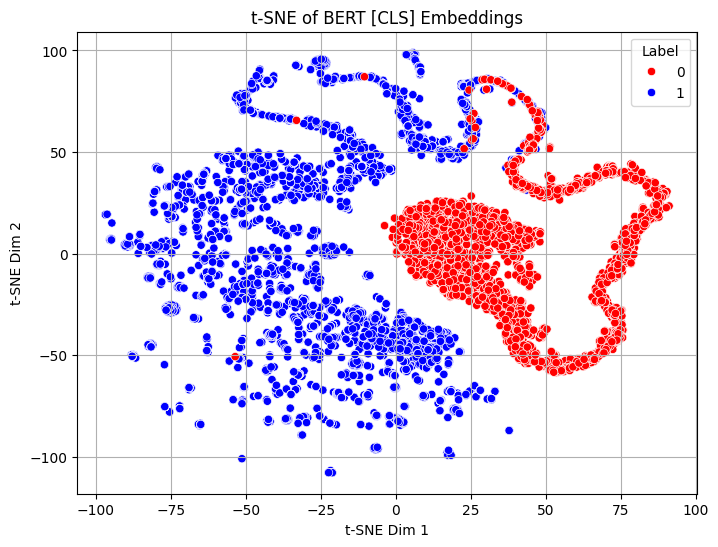

In [13]:
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

features = []
labels = []

model.eval()
with torch.no_grad():
    for input_ids, attn_mask, label in val_loader:
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
        outputs = model.bert(input_ids=input_ids, attention_mask=attn_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰
        features.append(cls_embeddings.cpu().numpy())
        labels.extend(label.numpy())

features = np.concatenate(features, axis=0)

# t-SNE 변환
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette=["red", "blue"], legend=["불리", "유리"])
plt.title("t-SNE of BERT [CLS] Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Label")
plt.grid(True)
plt.show()

C:\Users\xison\AppData\Local\Temp\ipykernel_9988\2665137415.py:32: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xison\AppData\Local\Temp\ipykernel_9988\2665137415.py:32: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xison\AppData\Local\Temp\ipykernel_9988\2665137415.py:32: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xison\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xison\anaconda3\envs\pytorch\lib\site-package

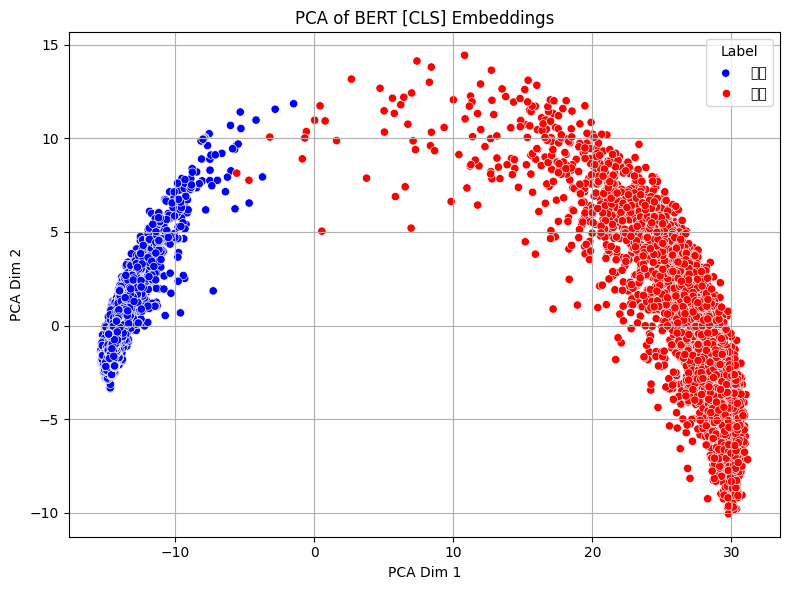

In [16]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

features = []
labels = []

model.eval()
with torch.no_grad():
    for input_ids, attn_mask, label in val_loader:
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
        outputs = model.bert(input_ids=input_ids, attention_mask=attn_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰
        features.append(cls_embeddings.cpu().numpy())
        labels.extend(label.numpy())

features = np.concatenate(features, axis=0)

# ✅ PCA 변환
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# ✅ 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette=["red", "blue"])
plt.title("PCA of BERT [CLS] Embeddings")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend(title="Label", labels=["불리", "유리"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import ConcatDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report
import torch

# ================================
# ✅ 환경 설정
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")  # KorSci-BERT
model = BertForSequenceClassification.from_pretrained(
    "kykim/bert-kor-base",
    num_labels=2,
    use_safetensors=True  # 보안 이슈 우회
).to(device)

# ================================
# ✅ 데이터셋 로드
# ================================
train_dataset = ConcatDataset([
    ClauseDataset('T_P', tokenizer, 1),
    ClauseDataset('T_N', tokenizer, 0)
])
val_dataset = ConcatDataset([
    ClauseDataset('V_P', tokenizer, 1),
    ClauseDataset('V_N', tokenizer, 0)
])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ================================
# ✅ 클래스 불균형 보정 Loss 설정
# ================================
pos_count = 5932
neg_count = 3172
total = pos_count + neg_count

# 불리(label=0), 유리(label=1)
class_weights = torch.tensor([total / neg_count, total / pos_count], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# ================================
# ✅ 학습 루프 함수
# ================================
def train(model, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(dataloader, desc="Train"):
        input_ids, attn_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

# ================================
# ✅ 검증 루프 함수
# ================================
def evaluate(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Val"):
            input_ids, attn_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    report = classification_report(all_labels, all_preds, target_names=["불리", "유리"], digits=4)
    return total_loss / len(dataloader), correct / total, report

# ================================
# ✅ 학습 실행 (최고 모델 저장 포함)
# ================================
best_acc = 0.0
early_stop_count = 0
EARLY_STOP = 3
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    print(f"\n🔁 Epoch {epoch}")
    
    # 🔹 학습
    train_loss, train_acc = train(model, train_loader)
    
    # 🔹 검증
    val_loss, val_acc, val_report = evaluate(model, val_loader)

    print(f"📘 Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"📗 Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")
    print(f"\n{val_report}")

    # ✅ 최고 성능 모델 저장
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_korsci_bert_model.pt")
        print("✅ Best model saved.")
        early_stop_count = 0
    else:
        early_stop_count += 1
        print(f"⏸ No improvement. Early stop count: {early_stop_count}")

    # ⛔️ 조기 종료 조건
    if early_stop_count >= EARLY_STOP:
        print("⛔️ Early stopping triggered.")
        break

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1


Val: 100%|██████████| 569/569 [00:39<00:00, 14.54it/s]


📘 Train Loss: 0.1453 | Acc: 0.9410
📗 Val Loss:   0.0425 | Acc: 0.9857

              precision    recall  f1-score   support

          불리     0.9984    0.9606    0.9791      3172
          유리     0.9793    0.9992    0.9892      5932

    accuracy                         0.9857      9104
   macro avg     0.9889    0.9799    0.9841      9104
weighted avg     0.9860    0.9857    0.9857      9104

✅ Best model saved.

🔁 Epoch 2


Val: 100%|██████████| 569/569 [00:39<00:00, 14.57it/s]


📘 Train Loss: 0.0422 | Acc: 0.9858
📗 Val Loss:   0.0103 | Acc: 0.9967

              precision    recall  f1-score   support

          불리     0.9990    0.9915    0.9953      3172
          유리     0.9955    0.9995    0.9975      5932

    accuracy                         0.9967      9104
   macro avg     0.9973    0.9955    0.9964      9104
weighted avg     0.9967    0.9967    0.9967      9104

✅ Best model saved.

🔁 Epoch 3


Val: 100%|██████████| 569/569 [00:39<00:00, 14.54it/s]


📘 Train Loss: 0.0184 | Acc: 0.9935
📗 Val Loss:   0.0817 | Acc: 0.9750

              precision    recall  f1-score   support

          불리     1.0000    0.9281    0.9627      3172
          유리     0.9630    1.0000    0.9811      5932

    accuracy                         0.9750      9104
   macro avg     0.9815    0.9641    0.9719      9104
weighted avg     0.9759    0.9750    0.9747      9104

⏸ No improvement. Early stop count: 1

🔁 Epoch 4


Val: 100%|██████████| 569/569 [00:39<00:00, 14.54it/s]


📘 Train Loss: 0.0138 | Acc: 0.9957
📗 Val Loss:   0.0098 | Acc: 0.9967

              precision    recall  f1-score   support

          불리     0.9997    0.9909    0.9953      3172
          유리     0.9951    0.9998    0.9975      5932

    accuracy                         0.9967      9104
   macro avg     0.9974    0.9953    0.9964      9104
weighted avg     0.9967    0.9967    0.9967      9104

⏸ No improvement. Early stop count: 2

🔁 Epoch 5


Val: 100%|██████████| 569/569 [00:39<00:00, 14.55it/s]


📘 Train Loss: 0.0029 | Acc: 0.9992
📗 Val Loss:   0.0066 | Acc: 0.9986

              precision    recall  f1-score   support

          불리     1.0000    0.9959    0.9979      3172
          유리     0.9978    1.0000    0.9989      5932

    accuracy                         0.9986      9104
   macro avg     0.9989    0.9980    0.9984      9104
weighted avg     0.9986    0.9986    0.9986      9104

✅ Best model saved.

🔁 Epoch 6


Val: 100%|██████████| 569/569 [00:39<00:00, 14.53it/s]


📘 Train Loss: 0.0113 | Acc: 0.9965
📗 Val Loss:   0.0123 | Acc: 0.9967

              precision    recall  f1-score   support

          불리     0.9987    0.9918    0.9953      3172
          유리     0.9956    0.9993    0.9975      5932

    accuracy                         0.9967      9104
   macro avg     0.9972    0.9956    0.9964      9104
weighted avg     0.9967    0.9967    0.9967      9104

⏸ No improvement. Early stop count: 1

🔁 Epoch 7


Val: 100%|██████████| 569/569 [00:39<00:00, 14.57it/s]


📘 Train Loss: 0.0083 | Acc: 0.9971
📗 Val Loss:   0.0004 | Acc: 0.9999

              precision    recall  f1-score   support

          불리     1.0000    0.9997    0.9998      3172
          유리     0.9998    1.0000    0.9999      5932

    accuracy                         0.9999      9104
   macro avg     0.9999    0.9998    0.9999      9104
weighted avg     0.9999    0.9999    0.9999      9104

✅ Best model saved.

🔁 Epoch 8


Val: 100%|██████████| 569/569 [00:39<00:00, 14.55it/s]


📘 Train Loss: 0.0072 | Acc: 0.9977
📗 Val Loss:   0.0021 | Acc: 0.9996

              precision    recall  f1-score   support

          불리     0.9994    0.9994    0.9994      3172
          유리     0.9997    0.9997    0.9997      5932

    accuracy                         0.9996      9104
   macro avg     0.9995    0.9995    0.9995      9104
weighted avg     0.9996    0.9996    0.9996      9104

⏸ No improvement. Early stop count: 1

🔁 Epoch 9


Val: 100%|██████████| 569/569 [00:39<00:00, 14.55it/s]


📘 Train Loss: 0.0048 | Acc: 0.9979
📗 Val Loss:   0.0064 | Acc: 0.9980

              precision    recall  f1-score   support

          불리     1.0000    0.9943    0.9972      3172
          유리     0.9970    1.0000    0.9985      5932

    accuracy                         0.9980      9104
   macro avg     0.9985    0.9972    0.9978      9104
weighted avg     0.9980    0.9980    0.9980      9104

⏸ No improvement. Early stop count: 2

🔁 Epoch 10


Val: 100%|██████████| 569/569 [00:39<00:00, 14.56it/s]

📘 Train Loss: 0.0089 | Acc: 0.9968
📗 Val Loss:   0.0188 | Acc: 0.9941

              precision    recall  f1-score   support

          불리     1.0000    0.9830    0.9914      3172
          유리     0.9910    1.0000    0.9955      5932

    accuracy                         0.9941      9104
   macro avg     0.9955    0.9915    0.9934      9104
weighted avg     0.9941    0.9941    0.9941      9104

⏸ No improvement. Early stop count: 3
⛔️ Early stopping triggered.


In [29]:
# 저장된 최고 모델 불러오기
model.load_state_dict(torch.load("best_korsci_bert_model.pt", map_location=device))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
import torch
import shap
from transformers import BertTokenizerFast, BertForSequenceClassification

# ✅ 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "kykim/bert-kor-base"

tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, use_safetensors=True)
model.load_state_dict(torch.load("best_korsci_bert_model.pt", map_location=device))
model.to(device)
model.eval()

# ✅ SHAP용 래퍼 클래스
class BertWrapper:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def __call__(self, texts):
        # ✅ SHAP 내부에서 batch 단위 입력이 들어오므로, 텍스트 여러 개 처리
        encodings = self.tokenizer(list(texts), return_tensors='pt', padding=True, truncation=True, max_length=128)
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        return probs.cpu().numpy()

# ✅ 입력 문장
sentence = "제2조(개인정보의 처리 및 보유기간) \n① 협회는 법령에 따른 개인정보 보유․이용기간 또는 정보주체로부터 개인정보를 수집시에 동의받은 개인정보 보유,이용기간 내에서 개인정보를 처리,보유합니다."
input_texts = [sentence]

# ✅ 예측 확인
wrapper = BertWrapper(model, tokenizer, device)
probs = wrapper(input_texts)[0]
label = int(probs.argmax())
confidence = probs[label]
print(f"✅ 예측 결과: {'유리' if label == 1 else '불리'} ({confidence:.4f})")

# ✅ SHAP 설명자
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(wrapper, masker)

# ✅ SHAP 실행
shap_values = explainer(input_texts)
shap.plots.text(shap_values[0])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 예측 결과: 유리 (1.0000)


In [31]:
import torch
import shap
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification

# ✅ 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "kykim/bert-kor-base"

tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, use_safetensors=True)
model.load_state_dict(torch.load("best_korsci_bert_model.pt", map_location=device))
model.to(device)
model.eval()

# ✅ SHAP용 래퍼 클래스
class BertWrapper:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def __call__(self, texts):
        encodings = self.tokenizer(list(texts), return_tensors='pt', padding=True, truncation=True, max_length=128)
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        return probs.cpu().numpy()

# ✅ 입력 문장
sentence = "제2조(개인정보의 처리 및 보유기간) \n① 협회는 법령에 따른 개인정보 보유․이용기간 또는 정보주체로부터 개인정보를 수집시에 동의받은 개인정보 보유,이용기간 내에서 개인정보를 처리,보유합니다."
input_texts = [sentence]

# ✅ 예측 결과 확인
wrapper = BertWrapper(model, tokenizer, device)
probs = wrapper(input_texts)[0]
label = int(probs.argmax())
confidence = probs[label]
print(f"✅ 예측 결과: {'유리' if label == 1 else '불리'} ({confidence:.4f})")

# ✅ SHAP 설명자 구성 및 계산
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(wrapper, masker)
shap_values = explainer(input_texts)

# ✅ SHAP 값과 대응 단어 추출
tokens = shap_values.data[0]            # 토큰 문자열 (단어 단위)
all_values = shap_values.values[0]      # (num_tokens, num_classes) 형상

# ✅ 유리 클래스(1) 기준 값 추출
values = all_values[:, 1]  # → 클래스 1에 대한 SHAP 값만 사용

# ✅ 상위 5개 단어 출력
top_n = 5
top_indices = np.argsort(np.abs(values))[-top_n:][::-1]  # 절댓값 기준 상위 N개

print("\n📌 상위 5개 영향 단어 (유리 클래스 기준):")
for idx in top_indices:
    print(f"  - '{tokens[idx]}': SHAP 값 = {values[idx]:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 예측 결과: 유리 (1.0000)

📌 상위 5개 영향 단어 (유리 클래스 기준):
  - '개인정보': SHAP 값 = 0.0488
  - '정보': SHAP 값 = 0.0464
  - '또는 ': SHAP 값 = 0.0459
  - '개인정보': SHAP 값 = 0.0454
  - '개인정보 ': SHAP 값 = 0.0434
